# Nuclear ANN 

### Load and preprocess data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/combined_fuel_weather_data.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Nuclear','Previous_Day','Previous_Year','Previous_2Day']].copy()


2024-10-30 14:59:38.034644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/lp/l5v0z5894r912dc6qp90m2j00000gn/T/ipykernel_3995/2845285853.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/combined_fuel_weather_data.csv')


In [3]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [4]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [6]:
# Large computation 
data['Previous_Year_Wind'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [7]:
cutoff_date = pd.to_datetime("2023-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Nuclear','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [8]:


usable_data['Previous_Day_Wind'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Wind'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [9]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Minute'] = usable_data['BeginDate'].dt.minute
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Month','Previous_2Day_Wind','Sum','Hour_of_Day','Previous_Year_Wind','solarradiation','Minute','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]


# Useless Features , ,
target = usable_data['Nuclear']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (92714, 17)
Target shape:  (92714,)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=80, validation_split=0.2, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/80


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1855/1855 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2513907.7500 - val_loss: 78439.7188
Epoch 2/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - loss: 68068.7188 - val_loss: 56714.6641
Epoch 3/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step - loss: 53901.6797 - val_loss: 50615.0234
Epoch 4/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - loss: 49101.2969 - val_loss: 44742.2344
Epoch 5/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step - loss: 41643.6328 - val_loss: 39919.8203
Epoch 6/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 39721.1055 - val_loss: 36825.3633
Epoch 7/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 36079.1523 - val_loss: 34531.9531
Epoch 8/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 32435.2246 - val_loss: 31339.0527
Epoch 9/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - loss: 30621.9863 - val_loss: 28148.0586
Epoch 10/80
1855/1855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 27316.2305 - val_loss: 26856.8359
Epoch 11/80
1855/1855 ━━━━━━━━━━━━━━━━

### Analysis

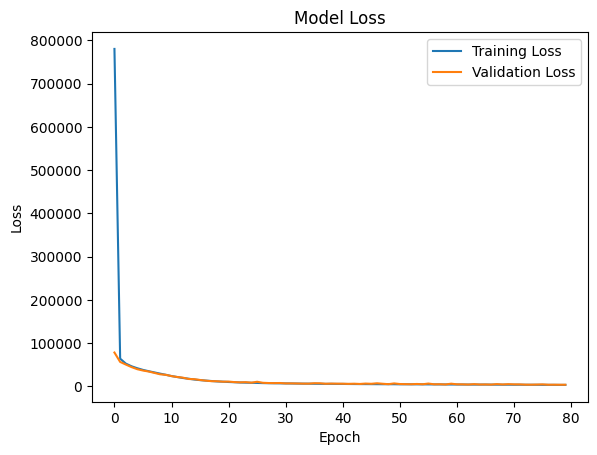

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [12]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


580/580 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
Predicted Solar Energy Ouput: [3393.670166015625, 2065.291259765625, 3327.523193359375, 3345.143310546875, 3362.070068359375, 3398.713134765625, 3368.443115234375, 3422.321044921875, 3317.02685546875, 3351.892822265625, 3440.108642578125, 1287.232666015625, 2992.410888671875, 1335.805908203125, 2148.2138671875, 3398.095947265625, 3459.17529296875, 3336.16552734375, 2157.321044921875, 3380.242919921875]
Actual Solar Energy Output: [3391. 2104. 3293. 3366. 3332. 3357. 3363. 3359. 3362. 3367. 3370. 1228.
 3041. 1230. 2119. 3358. 3359. 3370. 2122. 3351.]


In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 40.300305052019084
Mean Squared Error (MSE): 3675.266959996387
Root Mean Squared Error (RMSE): 60.623980073865056
Percent Error (PERR): 0.013469391894228884


### Save model

In [15]:
model.save('NuclearModel.h5')